In [ ]:
%cd yolov5_torch

In [2]:
import torch
import shap
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from cv2 import cv2

from utils.general import non_max_suppression, box_iou

device = "cpu"

In [3]:
import sys
!{sys.executable} -m pip install -q ipywidgets widgetsnbextension

In [4]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [5]:
img_size = 5*32

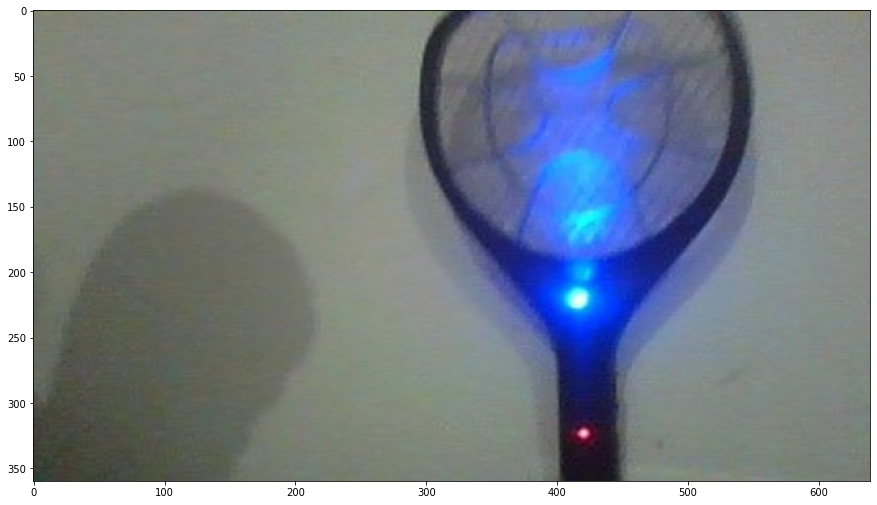

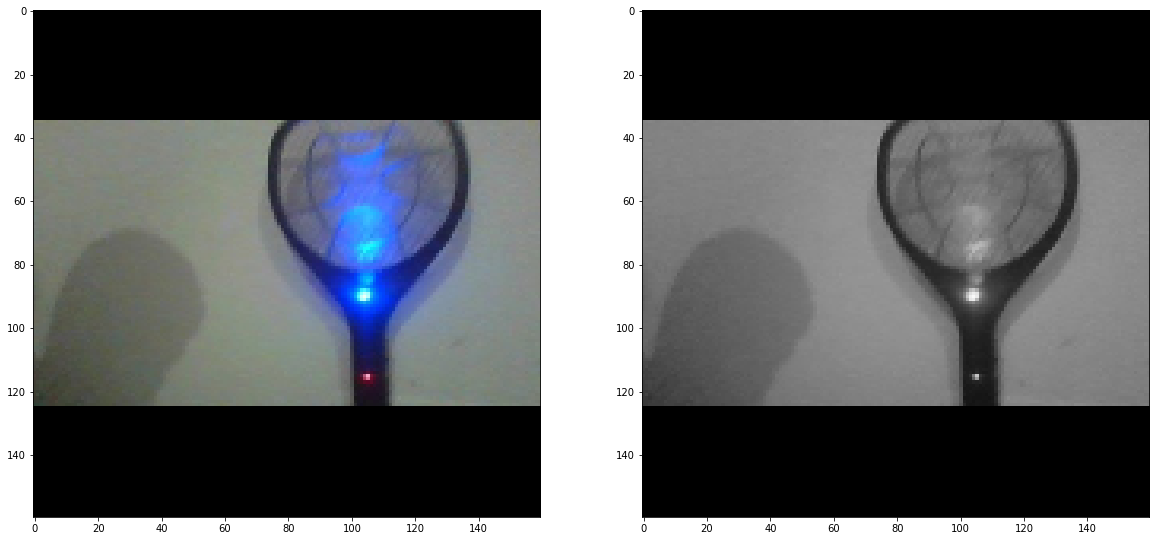

In [7]:
img_org = cv2.imread("../../data/preprocessed/train/images/20220108214820_1_WIN_20211231_19_18_56_Pro.jpg", cv2.IMREAD_COLOR)
img_org = cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB)

old_img_size = img_org.shape[:2] # old size is in (height, width) format

ratio = float(img_size)/max(old_img_size)
new_size_y, new_size_x = tuple([int(x*ratio) for x in old_img_size])

img = cv2.resize(img_org, (new_size_x, new_size_y))

delta_w = img_size - new_size_x
delta_h = img_size - new_size_y
top, bottom = delta_h//2, delta_h-(delta_h//2)
left, right = delta_w//2, delta_w-(delta_w//2)

color = [0, 0, 0]
img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
img = img.astype("float64")/255

img_gray = rgb2gray(img)    

plt.figure(figsize=(15, 15))
plt.imshow(img_org)
plt.show()

fig = plt.figure(figsize=(20, 40))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(img_gray, cmap='gray', vmin=0, vmax=1)
plt.show()

In [8]:
from torch import nn

class Ensemble(nn.ModuleList):
    def __init__(self):
        super().__init__()

    def forward(self, x, augment=False, profile=False, visualize=False):
        y = []
        for module in self:
            y.append(module(x, augment, profile, visualize)[0])
        y = torch.cat(y, 1)  # nms ensemble
        return y, None  # inference, train output

In [9]:
def attempt_load(weights, map_location=None, inplace=True, fuse=True):
    from models.yolo import Detect, Model

    # Loads an ensemble of models weights=[a,b,c] or a single model weights=[a] or weights=a
    model = Ensemble()
    for w in weights if isinstance(weights, list) else [weights]:
        ckpt = torch.load(w, map_location=map_location)  # load
        if fuse:
            model.append(ckpt['ema' if ckpt.get('ema') else 'model'].float().fuse().eval())  # FP32 model
        else:
            model.append(ckpt['ema' if ckpt.get('ema') else 'model'].float().eval())  # without layer fuse

    # Compatibility updates
    for m in model.modules():
        if type(m) in [nn.Hardswish, nn.LeakyReLU, nn.ReLU, nn.ReLU6, nn.SiLU, Detect, Model]:
            m.inplace = inplace  # pytorch 1.7.0 compatibility
            if type(m) is Detect:
                if not isinstance(m.anchor_grid, list):  # new Detect Layer compatibility
                    delattr(m, 'anchor_grid')
                    setattr(m, 'anchor_grid', [torch.zeros(1)] * m.nl)

    if len(model) == 1:
        return model[-1]  # return model

In [27]:
model = attempt_load("runs/train/exp5/best.pt", map_location=device).float().eval()

Fusing layers... 
Model Summary: 213 layers, 1761871 parameters, 0 gradients


In [28]:
confidence = 0.5
iou = 0.5

In [29]:
torch_image = torch.from_numpy(np.ascontiguousarray(img.transpose(2, 0, 1))).to(device).unsqueeze(0).float()
prediction = model(torch_image)

In [30]:
print(prediction[0].shape, "# (1 image) x (1575 positions for predictions) x (4 coordinates, 1 object score, 80 class probabilities)")
output = non_max_suppression(prediction[0], conf_thres=confidence, iou_thres=iou)
print(output[0], "#[x1, y1, x2, y2, class prob.*obj. score, class_index]")

torch.Size([1, 1575, 7]) # (1 image) x (1575 positions for predictions) x (4 coordinates, 1 object score, 80 class probabilities)
tensor([[ 63.90779,  36.31273, 147.66202, 122.94824,   0.89548,   1.00000],
        [ 99.31837, 110.51141, 111.48293, 119.26997,   0.63727,   0.00000],
        [ 97.94427,  85.16647, 110.03554,  94.82429,   0.60505,   0.00000]]) #[x1, y1, x2, y2, class prob.*obj. score, class_index]


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


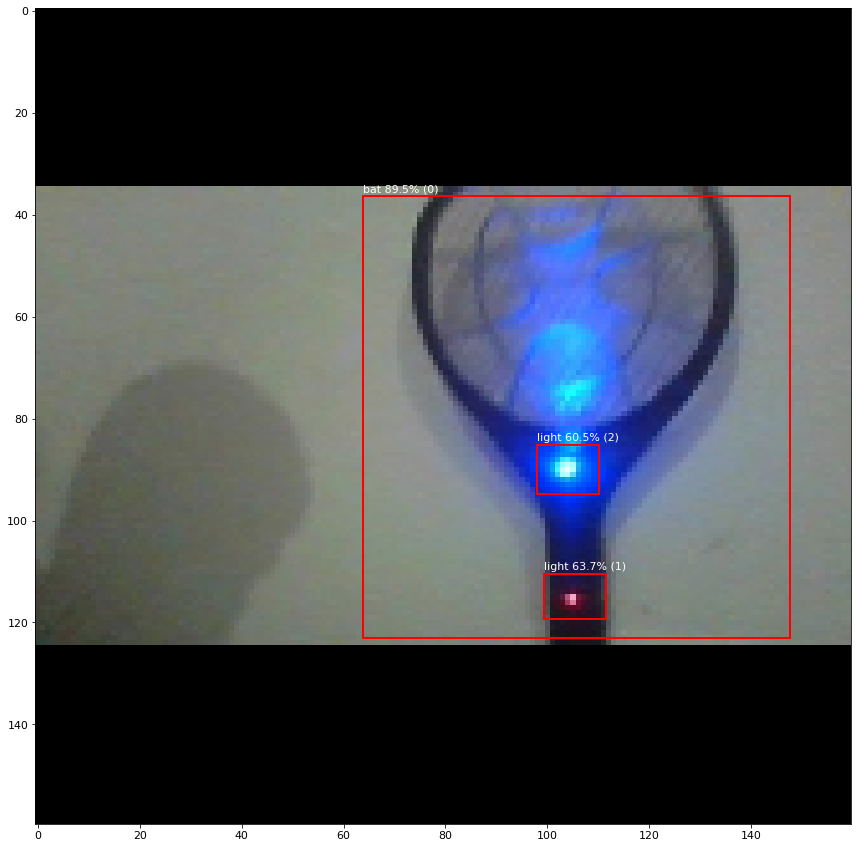

In [36]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1)

plt.imshow(img)
for i, detection in enumerate(output[0].cpu().numpy()):
    label = f"{model.names[int(detection[5])]} {detection[4]:0.1%} ({i})"
    bbox = patches.Rectangle(
        detection[:2],
        detection[2] - detection[0],
        detection[3] - detection[1],
        linewidth=2,
        edgecolor="r",
        facecolor="none",
    )
    plt.text(detection[0], detection[1] - 0.8, label, color="white")
    ax.add_patch(bbox)
plt.show()


In [47]:
class CastNumpy(torch.nn.Module):
    def __init__(self):
        super(CastNumpy, self).__init__()
  
    def forward(self, image):
        """
        In the forward function we accept the inputs and cast them to a pytorch tensor
        """

        image = np.ascontiguousarray(image)
        image = torch.from_numpy(image).to(device)
        if image.ndimension() == 3:
            image = image.unsqueeze(0)
        image_half = image.float()

        return image_half

numpy2torch_converter = CastNumpy()

In [48]:
numpy2torch_converter.forward(img.transpose(2, 0, 1))

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

In [49]:
class OD2Score(torch.nn.Module):
    def __init__(self, target, conf_thresh=0.01, iou_thresh=0.5):
        """
        constructor
        """
        super(OD2Score, self).__init__()
        self.conf_thresh = conf_thresh
        self.iou_thresh = iou_thresh
        self.target = torch.tensor(target, device=device)

    def forward(self, x):
        """
        In the forward function we accept the predictions and return the score for a selected target of the box
        """

        score_best_box = torch.zeros([x[0].shape[0]], device=device)

        for idx, img in enumerate(x[0]):
            img = img.unsqueeze(0)

            output = non_max_suppression(img, conf_thres=self.conf_thresh, iou_thres=self.iou_thresh)
            if output and output[0] is not None:
                correct_class_predictions = output[0][...,5] == self.target[5]
                correctly_labeled_boxes = output[0][correct_class_predictions]

                if correctly_labeled_boxes.shape[0]:
                    iou_with_target, _idx = box_iou(correctly_labeled_boxes[:,:4], self.target.unsqueeze(0)[:,:4]).max(1)
                    index_best_box_in_correct_class = torch.argmax(iou_with_target)
                    index_best_box_in_output = torch.where(output[0][...,5] == self.target[5])[0][index_best_box_in_correct_class]

                    score_best_box[idx] = output[0][index_best_box_in_output][4]*iou_with_target[index_best_box_in_correct_class]

        return score_best_box.cpu().numpy()

# look at the image output above and set the index of the object you want to analyze here
target_index = 0
target = output[0].cpu().numpy()[target_index,:]
scoring = OD2Score(target, conf_thresh=confidence, iou_thresh=iou)

In [50]:
print(scoring.forward(prediction), "# score for target prediction")

[    0.89548] # score for target prediction


In [51]:
class SuperPixler(torch.nn.Module):
    def __init__(self, image, super_pixel_width):
        super(SuperPixler, self).__init__()

        self.image = image.transpose(2, 0, 1) # model expects images in BRG, not RGB, so transpose color channels
        self.mean_color = self.image.mean()
        self.image = np.expand_dims(self.image, axis=0)
        self.image_width = image.shape[1]
        self.super_pixel_width = super_pixel_width

  
    def forward(self, x):
        """
        In the forward step we accept the super pixel masks and transform them to a batch of images
        """

        pixeled_image = np.repeat(self.image.copy(), x.shape[0], axis=0)

        for i, super_pixel in enumerate(x.T):
            images_to_pixelate = [bool(p) for p in super_pixel]
            x = (i*self.super_pixel_width//self.image_width)*self.super_pixel_width
            y = i*self.super_pixel_width%self.image_width
            pixeled_image[images_to_pixelate,:,x:x+self.super_pixel_width, y:y+self.super_pixel_width] = self.mean_color

        return pixeled_image

super_pixel_width = 16
assert (img_size/super_pixel_width)%1 == 0, "image width needs to be multiple of super pixel width"   
n_super_pixel = int((img.shape[1]/super_pixel_width)**2)

super_pixler = SuperPixler(img, super_pixel_width = super_pixel_width)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


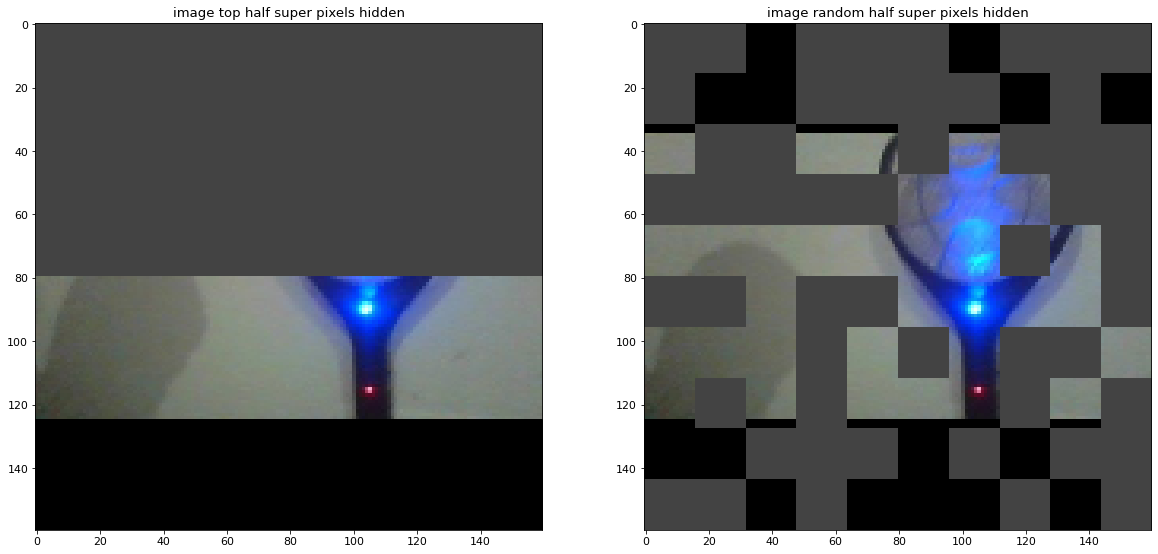

In [52]:
img_s = super_pixler.forward(np.array([[1 for _ in range(n_super_pixel//2)]+[0 for _ in range(n_super_pixel//2)], 
                                       [random.randint(0,1) for _ in range(n_super_pixel)]]))
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title("image top half super pixels hidden")
ax1.imshow(img_s[0,:,:,:].transpose(1,2,0))
ax2 = fig.add_subplot(1,2,2)
ax2.set_title("image random half super pixels hidden")
ax2.imshow(img_s[1,:,:,:].transpose(1,2,0))
plt.show()

In [53]:
super_pixel_model = torch.nn.Sequential(
    super_pixler,
    numpy2torch_converter,
    model,
    scoring
)

In [54]:
score = super_pixel_model(np.array([[1 for _ in range(n_super_pixel)]]))
print(score, "# score for whole image hidden")
score = super_pixel_model(np.array([[1 for _ in range(n_super_pixel)], # empty image
                                    [0 for _ in range(n_super_pixel)], # full image
                                    [1 for _ in range(n_super_pixel//2)]+[0 for _ in range(n_super_pixel//2)], # top half blacked out
                                    [random.randint(0,1) for _ in range(n_super_pixel)]])) # randomly half the patches blacked out
print(score, "# scores for all, none, top half, random half of the image hidden")

[          0] # score for whole image hidden
[          0     0.89548           0     0.76366] # scores for all, none, top half, random half of the image hidden


In [55]:
# use Kernel SHAP to explain the detection

background_super_pixel = np.array([[1 for _ in range(n_super_pixel)]])
image_super_pixel = np.array([[0 for _ in range(n_super_pixel)]])
kernel_explainer = shap.KernelExplainer(super_pixel_model, background_super_pixel)

# Very large values for nsamples cause OOM errors depending on image and super pixel parameter. We combine batches of SHAP values to distribute the load. 
collected_shap_values = np.zeros_like(background_super_pixel)
b = 25
for i in range(b):
    print(f"{i/b:0.2%}")

    shap_values = kernel_explainer.shap_values(image_super_pixel, nsamples=1000)

    # take shap value with highest abs. value for each pixel from each batch
    stacked_values = np.vstack([shap_values, collected_shap_values])
    index_max_values = np.argmax(np.abs(stacked_values), axis=0)
    collected_shap_values = stacked_values[index_max_values, range(shap_values.shape[1])]
print((collected_shap_values!=0).sum(), "non-zero shap values found")

# plot the found SHAP values. Expected value does not match due to merging of batches
shap.initjs()
shap.force_plot(kernel_explainer.expected_value, collected_shap_values)

0.00%


  0%|          | 0/1 [00:00<?, ?it/s]num_full_subsets = 0
remaining_weight_vector = [    0.19435    0.098166    0.066118    0.050105    0.040506    0.034114    0.029555    0.026142    0.023493    0.021378    0.019653     0.01822    0.017012     0.01598    0.015091    0.014316    0.013636    0.013036    0.012502    0.012025    0.011598    0.011212    0.010864    0.010549    0.010262        0.01
   0.0097618   0.0095439   0.0093446   0.0091621   0.0089951   0.0088421   0.0087022   0.0085742   0.0084574   0.0083509   0.0082542   0.0081666   0.0080876   0.0080169   0.0079539   0.0078984   0.0078501   0.0078086   0.0077739   0.0077458    0.007724   0.0077085   0.0076993   0.0076962]
num_paired_subset_sizes = 49
weight_left = 1.0
np.sum(w_aug) = 100.0
np.sum(self.kernelWeights) = 0.9999999999999998
phi = [   0.013394           0           0   0.0059476    0.019262           0   0.0066687           0           0           0           0           0           0    0.019964    0.021643     0.027

4.00%


  0%|          | 0/1 [00:00<?, ?it/s]num_full_subsets = 0
remaining_weight_vector = [    0.19435    0.098166    0.066118    0.050105    0.040506    0.034114    0.029555    0.026142    0.023493    0.021378    0.019653     0.01822    0.017012     0.01598    0.015091    0.014316    0.013636    0.013036    0.012502    0.012025    0.011598    0.011212    0.010864    0.010549    0.010262        0.01
   0.0097618   0.0095439   0.0093446   0.0091621   0.0089951   0.0088421   0.0087022   0.0085742   0.0084574   0.0083509   0.0082542   0.0081666   0.0080876   0.0080169   0.0079539   0.0078984   0.0078501   0.0078086   0.0077739   0.0077458    0.007724   0.0077085   0.0076993   0.0076962]
num_paired_subset_sizes = 49
weight_left = 1.0
np.sum(w_aug) = 100.0
np.sum(self.kernelWeights) = 0.9999999999999998
phi = [          0           0    0.012519   0.0030817           0           0           0           0           0    0.013051           0           0           0           0           0   0.00710

8.00%


  0%|          | 0/1 [00:00<?, ?it/s]num_full_subsets = 0
remaining_weight_vector = [    0.19435    0.098166    0.066118    0.050105    0.040506    0.034114    0.029555    0.026142    0.023493    0.021378    0.019653     0.01822    0.017012     0.01598    0.015091    0.014316    0.013636    0.013036    0.012502    0.012025    0.011598    0.011212    0.010864    0.010549    0.010262        0.01
   0.0097618   0.0095439   0.0093446   0.0091621   0.0089951   0.0088421   0.0087022   0.0085742   0.0084574   0.0083509   0.0082542   0.0081666   0.0080876   0.0080169   0.0079539   0.0078984   0.0078501   0.0078086   0.0077739   0.0077458    0.007724   0.0077085   0.0076993   0.0076962]
num_paired_subset_sizes = 49
weight_left = 1.0
np.sum(w_aug) = 100.0
np.sum(self.kernelWeights) = 1.0
phi = [          0           0           0           0           0    0.015658           0           0    0.019206           0           0           0   0.0041452           0           0           0           0 

12.00%


  0%|          | 0/1 [00:00<?, ?it/s]num_full_subsets = 0
remaining_weight_vector = [    0.19435    0.098166    0.066118    0.050105    0.040506    0.034114    0.029555    0.026142    0.023493    0.021378    0.019653     0.01822    0.017012     0.01598    0.015091    0.014316    0.013636    0.013036    0.012502    0.012025    0.011598    0.011212    0.010864    0.010549    0.010262        0.01
   0.0097618   0.0095439   0.0093446   0.0091621   0.0089951   0.0088421   0.0087022   0.0085742   0.0084574   0.0083509   0.0082542   0.0081666   0.0080876   0.0080169   0.0079539   0.0078984   0.0078501   0.0078086   0.0077739   0.0077458    0.007724   0.0077085   0.0076993   0.0076962]
num_paired_subset_sizes = 49
weight_left = 1.0
np.sum(w_aug) = 100.0
np.sum(self.kernelWeights) = 0.9999999999999998
phi = [          0           0    0.013688           0   0.0040996   0.0018119           0    0.023734           0           0   0.0025777           0           0    0.011675           0          

16.00%


  0%|          | 0/1 [00:00<?, ?it/s]num_full_subsets = 0
remaining_weight_vector = [    0.19435    0.098166    0.066118    0.050105    0.040506    0.034114    0.029555    0.026142    0.023493    0.021378    0.019653     0.01822    0.017012     0.01598    0.015091    0.014316    0.013636    0.013036    0.012502    0.012025    0.011598    0.011212    0.010864    0.010549    0.010262        0.01
   0.0097618   0.0095439   0.0093446   0.0091621   0.0089951   0.0088421   0.0087022   0.0085742   0.0084574   0.0083509   0.0082542   0.0081666   0.0080876   0.0080169   0.0079539   0.0078984   0.0078501   0.0078086   0.0077739   0.0077458    0.007724   0.0077085   0.0076993   0.0076962]
num_paired_subset_sizes = 49
weight_left = 1.0
np.sum(w_aug) = 100.0
np.sum(self.kernelWeights) = 0.9999999999999997
phi = [          0           0           0           0           0           0           0           0           0   0.0088423   0.0065186     0.01152           0   0.0059241           0          

20.00%


  0%|          | 0/1 [00:00<?, ?it/s]num_full_subsets = 0
remaining_weight_vector = [    0.19435    0.098166    0.066118    0.050105    0.040506    0.034114    0.029555    0.026142    0.023493    0.021378    0.019653     0.01822    0.017012     0.01598    0.015091    0.014316    0.013636    0.013036    0.012502    0.012025    0.011598    0.011212    0.010864    0.010549    0.010262        0.01
   0.0097618   0.0095439   0.0093446   0.0091621   0.0089951   0.0088421   0.0087022   0.0085742   0.0084574   0.0083509   0.0082542   0.0081666   0.0080876   0.0080169   0.0079539   0.0078984   0.0078501   0.0078086   0.0077739   0.0077458    0.007724   0.0077085   0.0076993   0.0076962]
num_paired_subset_sizes = 49
weight_left = 1.0
np.sum(w_aug) = 100.0
np.sum(self.kernelWeights) = 0.9999999999999998
phi = [          0           0    0.014154           0           0           0           0           0    0.021826           0           0  0.00069109           0   0.0031416   0.0013057          

24.00%


  0%|          | 0/1 [00:00<?, ?it/s]num_full_subsets = 0
remaining_weight_vector = [    0.19435    0.098166    0.066118    0.050105    0.040506    0.034114    0.029555    0.026142    0.023493    0.021378    0.019653     0.01822    0.017012     0.01598    0.015091    0.014316    0.013636    0.013036    0.012502    0.012025    0.011598    0.011212    0.010864    0.010549    0.010262        0.01
   0.0097618   0.0095439   0.0093446   0.0091621   0.0089951   0.0088421   0.0087022   0.0085742   0.0084574   0.0083509   0.0082542   0.0081666   0.0080876   0.0080169   0.0079539   0.0078984   0.0078501   0.0078086   0.0077739   0.0077458    0.007724   0.0077085   0.0076993   0.0076962]
num_paired_subset_sizes = 49
weight_left = 1.0
np.sum(w_aug) = 100.0
np.sum(self.kernelWeights) = 0.9999999999999997
phi = [  0.0053939   0.0090458   0.0080941           0           0           0           0           0           0           0   0.0030637           0           0    0.019596           0          

28.00%


  0%|          | 0/1 [00:00<?, ?it/s]num_full_subsets = 0
remaining_weight_vector = [    0.19435    0.098166    0.066118    0.050105    0.040506    0.034114    0.029555    0.026142    0.023493    0.021378    0.019653     0.01822    0.017012     0.01598    0.015091    0.014316    0.013636    0.013036    0.012502    0.012025    0.011598    0.011212    0.010864    0.010549    0.010262        0.01
   0.0097618   0.0095439   0.0093446   0.0091621   0.0089951   0.0088421   0.0087022   0.0085742   0.0084574   0.0083509   0.0082542   0.0081666   0.0080876   0.0080169   0.0079539   0.0078984   0.0078501   0.0078086   0.0077739   0.0077458    0.007724   0.0077085   0.0076993   0.0076962]
num_paired_subset_sizes = 49
weight_left = 1.0
np.sum(w_aug) = 100.0
np.sum(self.kernelWeights) = 1.0000000000000002
phi = [          0           0           0           0           0    0.012468           0    0.010892           0           0           0           0   0.0088678    0.011617    0.003963          

32.00%


  0%|          | 0/1 [00:00<?, ?it/s]num_full_subsets = 0
remaining_weight_vector = [    0.19435    0.098166    0.066118    0.050105    0.040506    0.034114    0.029555    0.026142    0.023493    0.021378    0.019653     0.01822    0.017012     0.01598    0.015091    0.014316    0.013636    0.013036    0.012502    0.012025    0.011598    0.011212    0.010864    0.010549    0.010262        0.01
   0.0097618   0.0095439   0.0093446   0.0091621   0.0089951   0.0088421   0.0087022   0.0085742   0.0084574   0.0083509   0.0082542   0.0081666   0.0080876   0.0080169   0.0079539   0.0078984   0.0078501   0.0078086   0.0077739   0.0077458    0.007724   0.0077085   0.0076993   0.0076962]
num_paired_subset_sizes = 49
weight_left = 1.0
np.sum(w_aug) = 100.0
np.sum(self.kernelWeights) = 0.9999999999999999
phi = [  0.0037702           0           0   0.0055486    0.018724    0.019402    0.029869           0    0.015609    0.014233           0           0           0           0           0          

36.00%


  0%|          | 0/1 [00:00<?, ?it/s]num_full_subsets = 0
remaining_weight_vector = [    0.19435    0.098166    0.066118    0.050105    0.040506    0.034114    0.029555    0.026142    0.023493    0.021378    0.019653     0.01822    0.017012     0.01598    0.015091    0.014316    0.013636    0.013036    0.012502    0.012025    0.011598    0.011212    0.010864    0.010549    0.010262        0.01
   0.0097618   0.0095439   0.0093446   0.0091621   0.0089951   0.0088421   0.0087022   0.0085742   0.0084574   0.0083509   0.0082542   0.0081666   0.0080876   0.0080169   0.0079539   0.0078984   0.0078501   0.0078086   0.0077739   0.0077458    0.007724   0.0077085   0.0076993   0.0076962]
num_paired_subset_sizes = 49
weight_left = 1.0
np.sum(w_aug) = 100.0
np.sum(self.kernelWeights) = 1.0000000000000002
phi = [          0           0           0           0           0           0    0.014716   0.0083116    0.038946           0           0           0           0           0           0          

40.00%


  0%|          | 0/1 [00:00<?, ?it/s]num_full_subsets = 0
remaining_weight_vector = [    0.19435    0.098166    0.066118    0.050105    0.040506    0.034114    0.029555    0.026142    0.023493    0.021378    0.019653     0.01822    0.017012     0.01598    0.015091    0.014316    0.013636    0.013036    0.012502    0.012025    0.011598    0.011212    0.010864    0.010549    0.010262        0.01
   0.0097618   0.0095439   0.0093446   0.0091621   0.0089951   0.0088421   0.0087022   0.0085742   0.0084574   0.0083509   0.0082542   0.0081666   0.0080876   0.0080169   0.0079539   0.0078984   0.0078501   0.0078086   0.0077739   0.0077458    0.007724   0.0077085   0.0076993   0.0076962]
num_paired_subset_sizes = 49
weight_left = 1.0
np.sum(w_aug) = 99.99999999999999
np.sum(self.kernelWeights) = 0.9999999999999998
phi = [   0.011891    0.017878           0           0           0           0           0           0   0.0028595           0           0           0    0.010601    0.019017    0.0185

44.00%


  0%|          | 0/1 [00:00<?, ?it/s]num_full_subsets = 0
remaining_weight_vector = [    0.19435    0.098166    0.066118    0.050105    0.040506    0.034114    0.029555    0.026142    0.023493    0.021378    0.019653     0.01822    0.017012     0.01598    0.015091    0.014316    0.013636    0.013036    0.012502    0.012025    0.011598    0.011212    0.010864    0.010549    0.010262        0.01
   0.0097618   0.0095439   0.0093446   0.0091621   0.0089951   0.0088421   0.0087022   0.0085742   0.0084574   0.0083509   0.0082542   0.0081666   0.0080876   0.0080169   0.0079539   0.0078984   0.0078501   0.0078086   0.0077739   0.0077458    0.007724   0.0077085   0.0076993   0.0076962]
num_paired_subset_sizes = 49
weight_left = 1.0
np.sum(w_aug) = 100.0
np.sum(self.kernelWeights) = 1.0
phi = [          0           0           0    0.014431           0    0.015596    0.024307           0           0           0   0.0072412           0           0           0           0           0    0.012283 

48.00%


  0%|          | 0/1 [00:00<?, ?it/s]num_full_subsets = 0
remaining_weight_vector = [    0.19435    0.098166    0.066118    0.050105    0.040506    0.034114    0.029555    0.026142    0.023493    0.021378    0.019653     0.01822    0.017012     0.01598    0.015091    0.014316    0.013636    0.013036    0.012502    0.012025    0.011598    0.011212    0.010864    0.010549    0.010262        0.01
   0.0097618   0.0095439   0.0093446   0.0091621   0.0089951   0.0088421   0.0087022   0.0085742   0.0084574   0.0083509   0.0082542   0.0081666   0.0080876   0.0080169   0.0079539   0.0078984   0.0078501   0.0078086   0.0077739   0.0077458    0.007724   0.0077085   0.0076993   0.0076962]
num_paired_subset_sizes = 49
weight_left = 1.0
np.sum(w_aug) = 100.0
np.sum(self.kernelWeights) = 1.0000000000000002
phi = [          0           0   0.0071071   0.0016828   0.0024253    0.018106           0           0           0           0   0.0025302           0           0  0.00065062           0          

52.00%


  0%|          | 0/1 [00:00<?, ?it/s]num_full_subsets = 0
remaining_weight_vector = [    0.19435    0.098166    0.066118    0.050105    0.040506    0.034114    0.029555    0.026142    0.023493    0.021378    0.019653     0.01822    0.017012     0.01598    0.015091    0.014316    0.013636    0.013036    0.012502    0.012025    0.011598    0.011212    0.010864    0.010549    0.010262        0.01
   0.0097618   0.0095439   0.0093446   0.0091621   0.0089951   0.0088421   0.0087022   0.0085742   0.0084574   0.0083509   0.0082542   0.0081666   0.0080876   0.0080169   0.0079539   0.0078984   0.0078501   0.0078086   0.0077739   0.0077458    0.007724   0.0077085   0.0076993   0.0076962]
num_paired_subset_sizes = 49
weight_left = 1.0
np.sum(w_aug) = 100.0
np.sum(self.kernelWeights) = 0.9999999999999997
phi = [          0           0           0           0           0           0           0    0.011823   0.0050332   0.0049126           0           0    0.021753           0           0    0.0255

56.00%


  0%|          | 0/1 [00:00<?, ?it/s]num_full_subsets = 0
remaining_weight_vector = [    0.19435    0.098166    0.066118    0.050105    0.040506    0.034114    0.029555    0.026142    0.023493    0.021378    0.019653     0.01822    0.017012     0.01598    0.015091    0.014316    0.013636    0.013036    0.012502    0.012025    0.011598    0.011212    0.010864    0.010549    0.010262        0.01
   0.0097618   0.0095439   0.0093446   0.0091621   0.0089951   0.0088421   0.0087022   0.0085742   0.0084574   0.0083509   0.0082542   0.0081666   0.0080876   0.0080169   0.0079539   0.0078984   0.0078501   0.0078086   0.0077739   0.0077458    0.007724   0.0077085   0.0076993   0.0076962]
num_paired_subset_sizes = 49
weight_left = 1.0
np.sum(w_aug) = 100.0
np.sum(self.kernelWeights) = 0.9999999999999998
phi = [          0           0           0           0           0           0           0      0.0174    0.034459  6.7211e-06  0.00076239    0.017996           0   0.0043224   0.0027711          

60.00%


  0%|          | 0/1 [00:00<?, ?it/s]num_full_subsets = 0
remaining_weight_vector = [    0.19435    0.098166    0.066118    0.050105    0.040506    0.034114    0.029555    0.026142    0.023493    0.021378    0.019653     0.01822    0.017012     0.01598    0.015091    0.014316    0.013636    0.013036    0.012502    0.012025    0.011598    0.011212    0.010864    0.010549    0.010262        0.01
   0.0097618   0.0095439   0.0093446   0.0091621   0.0089951   0.0088421   0.0087022   0.0085742   0.0084574   0.0083509   0.0082542   0.0081666   0.0080876   0.0080169   0.0079539   0.0078984   0.0078501   0.0078086   0.0077739   0.0077458    0.007724   0.0077085   0.0076993   0.0076962]
num_paired_subset_sizes = 49
weight_left = 1.0
np.sum(w_aug) = 100.0
np.sum(self.kernelWeights) = 1.0000000000000004
phi = [          0           0           0    0.012962           0           0           0           0           0           0           0           0           0           0   0.0077261   0.00213

64.00%


  0%|          | 0/1 [00:00<?, ?it/s]num_full_subsets = 0
remaining_weight_vector = [    0.19435    0.098166    0.066118    0.050105    0.040506    0.034114    0.029555    0.026142    0.023493    0.021378    0.019653     0.01822    0.017012     0.01598    0.015091    0.014316    0.013636    0.013036    0.012502    0.012025    0.011598    0.011212    0.010864    0.010549    0.010262        0.01
   0.0097618   0.0095439   0.0093446   0.0091621   0.0089951   0.0088421   0.0087022   0.0085742   0.0084574   0.0083509   0.0082542   0.0081666   0.0080876   0.0080169   0.0079539   0.0078984   0.0078501   0.0078086   0.0077739   0.0077458    0.007724   0.0077085   0.0076993   0.0076962]
num_paired_subset_sizes = 49
weight_left = 1.0
np.sum(w_aug) = 100.0
np.sum(self.kernelWeights) = 0.9999999999999998
phi = [ -0.0037159     0.02436   0.0053698           0           0           0           0   0.0076035           0           0           0       0.026           0    0.022464           0          

68.00%


  0%|          | 0/1 [00:00<?, ?it/s]num_full_subsets = 0
remaining_weight_vector = [    0.19435    0.098166    0.066118    0.050105    0.040506    0.034114    0.029555    0.026142    0.023493    0.021378    0.019653     0.01822    0.017012     0.01598    0.015091    0.014316    0.013636    0.013036    0.012502    0.012025    0.011598    0.011212    0.010864    0.010549    0.010262        0.01
   0.0097618   0.0095439   0.0093446   0.0091621   0.0089951   0.0088421   0.0087022   0.0085742   0.0084574   0.0083509   0.0082542   0.0081666   0.0080876   0.0080169   0.0079539   0.0078984   0.0078501   0.0078086   0.0077739   0.0077458    0.007724   0.0077085   0.0076993   0.0076962]
num_paired_subset_sizes = 49
weight_left = 1.0
np.sum(w_aug) = 100.0
np.sum(self.kernelWeights) = 1.0
phi = [          0           0           0           0           0   0.0059208   0.0091573           0           0           0           0           0           0           0           0    0.013723     0.01746 

72.00%


  0%|          | 0/1 [00:00<?, ?it/s]num_full_subsets = 0
remaining_weight_vector = [    0.19435    0.098166    0.066118    0.050105    0.040506    0.034114    0.029555    0.026142    0.023493    0.021378    0.019653     0.01822    0.017012     0.01598    0.015091    0.014316    0.013636    0.013036    0.012502    0.012025    0.011598    0.011212    0.010864    0.010549    0.010262        0.01
   0.0097618   0.0095439   0.0093446   0.0091621   0.0089951   0.0088421   0.0087022   0.0085742   0.0084574   0.0083509   0.0082542   0.0081666   0.0080876   0.0080169   0.0079539   0.0078984   0.0078501   0.0078086   0.0077739   0.0077458    0.007724   0.0077085   0.0076993   0.0076962]
num_paired_subset_sizes = 49
weight_left = 1.0
np.sum(w_aug) = 100.0
np.sum(self.kernelWeights) = 1.0000000000000004
phi = [          0           0           0     0.00959    0.034389           0           0           0           0           0           0           0           0           0           0          

76.00%


  0%|          | 0/1 [00:00<?, ?it/s]num_full_subsets = 0
remaining_weight_vector = [    0.19435    0.098166    0.066118    0.050105    0.040506    0.034114    0.029555    0.026142    0.023493    0.021378    0.019653     0.01822    0.017012     0.01598    0.015091    0.014316    0.013636    0.013036    0.012502    0.012025    0.011598    0.011212    0.010864    0.010549    0.010262        0.01
   0.0097618   0.0095439   0.0093446   0.0091621   0.0089951   0.0088421   0.0087022   0.0085742   0.0084574   0.0083509   0.0082542   0.0081666   0.0080876   0.0080169   0.0079539   0.0078984   0.0078501   0.0078086   0.0077739   0.0077458    0.007724   0.0077085   0.0076993   0.0076962]
num_paired_subset_sizes = 49
weight_left = 1.0
np.sum(w_aug) = 100.0
np.sum(self.kernelWeights) = 0.9999999999999997
phi = [          0           0           0           0           0   0.0082759   0.0079872           0    0.012248           0           0           0   0.0083922           0           0    0.0204

80.00%


  0%|          | 0/1 [00:00<?, ?it/s]num_full_subsets = 0
remaining_weight_vector = [    0.19435    0.098166    0.066118    0.050105    0.040506    0.034114    0.029555    0.026142    0.023493    0.021378    0.019653     0.01822    0.017012     0.01598    0.015091    0.014316    0.013636    0.013036    0.012502    0.012025    0.011598    0.011212    0.010864    0.010549    0.010262        0.01
   0.0097618   0.0095439   0.0093446   0.0091621   0.0089951   0.0088421   0.0087022   0.0085742   0.0084574   0.0083509   0.0082542   0.0081666   0.0080876   0.0080169   0.0079539   0.0078984   0.0078501   0.0078086   0.0077739   0.0077458    0.007724   0.0077085   0.0076993   0.0076962]
num_paired_subset_sizes = 49
weight_left = 1.0
np.sum(w_aug) = 100.0
np.sum(self.kernelWeights) = 1.0000000000000002
phi = [          0           0           0   0.0075647           0    0.027861           0           0           0           0           0    0.015186           0           0   0.0059795          

84.00%


  0%|          | 0/1 [00:00<?, ?it/s]num_full_subsets = 0
remaining_weight_vector = [    0.19435    0.098166    0.066118    0.050105    0.040506    0.034114    0.029555    0.026142    0.023493    0.021378    0.019653     0.01822    0.017012     0.01598    0.015091    0.014316    0.013636    0.013036    0.012502    0.012025    0.011598    0.011212    0.010864    0.010549    0.010262        0.01
   0.0097618   0.0095439   0.0093446   0.0091621   0.0089951   0.0088421   0.0087022   0.0085742   0.0084574   0.0083509   0.0082542   0.0081666   0.0080876   0.0080169   0.0079539   0.0078984   0.0078501   0.0078086   0.0077739   0.0077458    0.007724   0.0077085   0.0076993   0.0076962]
num_paired_subset_sizes = 49
weight_left = 1.0
np.sum(w_aug) = 100.0
np.sum(self.kernelWeights) = 1.0000000000000004
phi = [          0           0           0   0.0026629           0   0.0028358           0           0   0.0092441           0           0   0.0039851           0    0.006883    0.010779          

88.00%


  0%|          | 0/1 [00:00<?, ?it/s]num_full_subsets = 0
remaining_weight_vector = [    0.19435    0.098166    0.066118    0.050105    0.040506    0.034114    0.029555    0.026142    0.023493    0.021378    0.019653     0.01822    0.017012     0.01598    0.015091    0.014316    0.013636    0.013036    0.012502    0.012025    0.011598    0.011212    0.010864    0.010549    0.010262        0.01
   0.0097618   0.0095439   0.0093446   0.0091621   0.0089951   0.0088421   0.0087022   0.0085742   0.0084574   0.0083509   0.0082542   0.0081666   0.0080876   0.0080169   0.0079539   0.0078984   0.0078501   0.0078086   0.0077739   0.0077458    0.007724   0.0077085   0.0076993   0.0076962]
num_paired_subset_sizes = 49
weight_left = 1.0
np.sum(w_aug) = 100.00000000000001
np.sum(self.kernelWeights) = 0.9999999999999998
phi = [          0           0    0.013126           0           0           0   0.0078491           0           0           0   0.0010705   0.0062819    0.010534           0   0.0090

92.00%


  0%|          | 0/1 [00:00<?, ?it/s]num_full_subsets = 0
remaining_weight_vector = [    0.19435    0.098166    0.066118    0.050105    0.040506    0.034114    0.029555    0.026142    0.023493    0.021378    0.019653     0.01822    0.017012     0.01598    0.015091    0.014316    0.013636    0.013036    0.012502    0.012025    0.011598    0.011212    0.010864    0.010549    0.010262        0.01
   0.0097618   0.0095439   0.0093446   0.0091621   0.0089951   0.0088421   0.0087022   0.0085742   0.0084574   0.0083509   0.0082542   0.0081666   0.0080876   0.0080169   0.0079539   0.0078984   0.0078501   0.0078086   0.0077739   0.0077458    0.007724   0.0077085   0.0076993   0.0076962]
num_paired_subset_sizes = 49
weight_left = 1.0
np.sum(w_aug) = 100.0
np.sum(self.kernelWeights) = 1.0000000000000002
phi = [   0.016911           0           0    0.010174           0    0.018145           0   0.0048544           0   0.0019841           0           0           0    0.013452           0   0.00695

96.00%


  0%|          | 0/1 [00:00<?, ?it/s]num_full_subsets = 0
remaining_weight_vector = [    0.19435    0.098166    0.066118    0.050105    0.040506    0.034114    0.029555    0.026142    0.023493    0.021378    0.019653     0.01822    0.017012     0.01598    0.015091    0.014316    0.013636    0.013036    0.012502    0.012025    0.011598    0.011212    0.010864    0.010549    0.010262        0.01
   0.0097618   0.0095439   0.0093446   0.0091621   0.0089951   0.0088421   0.0087022   0.0085742   0.0084574   0.0083509   0.0082542   0.0081666   0.0080876   0.0080169   0.0079539   0.0078984   0.0078501   0.0078086   0.0077739   0.0077458    0.007724   0.0077085   0.0076993   0.0076962]
num_paired_subset_sizes = 49
weight_left = 1.0
np.sum(w_aug) = 100.0
np.sum(self.kernelWeights) = 0.9999999999999999
phi = [   0.012279           0           0   0.0042786    0.014614           0           0           0           0           0   0.0042406           0           0           0           0   0.00307

100 non-zero shap values found


In [57]:
# match super pixels back to image pixels
shap_to_pixel = collected_shap_values.reshape(img_size//super_pixel_width, img_size//super_pixel_width)# reshape to square
shap_to_pixel = np.repeat(shap_to_pixel, super_pixel_width, axis=0)# extend superpixles to the right
shap_to_pixel = np.repeat(shap_to_pixel, super_pixel_width, axis=1)# and down
shap_to_pixel = shap_to_pixel/(np.max(np.abs(collected_shap_values))*2) + 0.5 # center values between 0 and 1 for the colour map

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


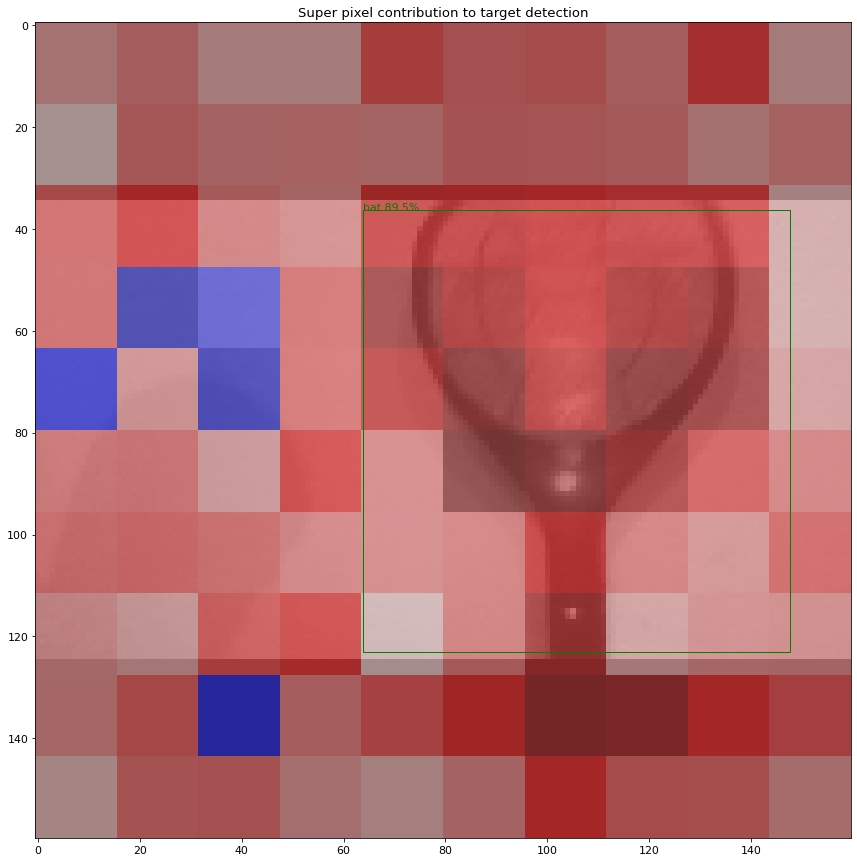

In [58]:
# plot image and shap values for super pixels on top
fig, ax = plt.subplots(1, 1, figsize=(15,15))
ax.set_title("Super pixel contribution to target detection")
ax.imshow(img_gray, alpha=0.7, cmap='gray', vmin=0, vmax=1)
ax.imshow(shap_to_pixel, cmap=plt.cm.seismic, vmin=0, vmax=1, alpha=0.5)

# Add bounding box of target
label = f"{model.names[int(target[5])]} {target[4]:0.1%}"
plt.text(target[0], target[1], label, color="green")
bbox = patches.Rectangle(target[:2], target[2]-target[0], target[3]-target[1], linewidth=1, edgecolor='g', facecolor='none')
ax.add_patch(bbox)
plt.show()